In [55]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [123]:
def distance_bottom_left(img, pt):
    h, w = np.shape(img)[:2]
    return np.linalg.norm(np.array([0, h]) - pt)

def distance_bottom_right(img, pt):
    h, w = np.shape(img)[:2]
    return np.linalg.norm(np.array([w, h]) - pt)

In [152]:
def filter_red(image):
    result = image.copy()
    lower = np.array([0,0,0])
    upper = np.array([255,50,50])
    mask = cv2.inRange(result, lower, upper)
    result = cv2.bitwise_and(result, result, mask=mask)
    return result
    
def blur_and_canny(image, k=9):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    gray = cv2.medianBlur(gray,k)
    lines = cv2.Canny(gray,40,140)
    return lines

def sort_bottom_left_CCW(image, cnt):
    if len(cnt) == 0:
        return []
    return np.array([min(cnt, key=lambda pt: distance_bottom_left(image, pt))[0],
            min(cnt, key=lambda pt: distance_bottom_right(image, pt))[0],
            max(cnt, key=lambda pt: distance_bottom_left(image, pt))[0],
            max(cnt, key=lambda pt: distance_bottom_right(image, pt))[0]])

def compute_homography(image, cnt):
    h, w, _ = np.shape(image)
    ptsA = sort_bottom_left_CCW(image, cnt)
    ptsB = np.array([[0, h], [w, h], [w, 0], [0, 0]])
    (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
    aligned = cv2.warpPerspective(image, H, (w, h))
    return aligned

def find_biggest_contours(image, num_contours=4):
    contours,hierarchy = cv2.findContours(image,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(contours, key=cv2.contourArea, reverse=True)[:num_contours]
    return cnts

#     print(np.shape(cnt))
#     print(min(cnt, key=lambda pt: distance_bottom_left(image, pt)), max(cnt, key=lambda pt: distance_bottom_left(image, pt)))
#     print(min(cnt, key=lambda pt: distance_bottom_right(image, pt)), max(cnt, key=lambda pt: distance_bottom_right(image, pt)))
#     x,y,w,h = cv2.boundingRect(cnt)
#     crop = image[y:y+h,x:x+w,:]
#     crop = image.copy()
#     cv2.drawContours(crop, cnt, -1, (0, 255, 0), 3)

In [154]:
# try:
#     if not os.path.exists('data'):
#         os.makedirs('data')
# except OSError:
#     print('Error: Creating directory of data')

# Playing video from file:
vid = cv2.VideoCapture('videos/20201127_171040.mp4')

currentFrame = 0

# plt.subplot(131)
# ax1=plt.subplot(1, 3, 1)
# ax2=plt.subplot(1, 3, 2)
# ax3=plt.subplot(1, 3, 3)

bottom_left_y = []

while(vid.isOpened()):
    # Capture frame by frame
    ret, frame = vid.read()
    image = cv2.rotate(frame, cv2.cv2.ROTATE_90_CLOCKWISE) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    result = filter_red(image)
    lines = blur_and_canny(result)
    
    cnt = find_biggest_contours(lines)[0]
    
    aligned = compute_homography(image, cnt)
    
    new_masked = filter_red(aligned)
    new_lines = blur_and_canny(new_masked, k=11)
    cnts = find_biggest_contours(new_lines)
#     print(np.shape(contours))
#     print(cnts[0])
    centers_image_frame = [np.mean(cnt[0], axis=0) for cnt in cnts]
    new_h, new_w = np.shape(new_lines)
    
    REAL_H, REAL_W = 10, 23
    real_centers = [[(x/new_w)*REAL_W, (y/new_h)*REAL_H] for x, y in centers_image_frame]
    real_centers = sort_bottom_left_CCW(new_lines, np.reshape(real_centers, [-1, 1, 2]))
#     print(centers_image_frame)
#     print(real_centers)
    if len(real_centers) > 0:
        bottom_left_y.append(real_centers[0][1])

#     ax1.imshow(gray)
#     ax2.imshow(aligned)
#     ax3.imshow(new_lines)
    
    currentFrame += 1
    
    cv2.drawContours(image, cnt, -1, (0, 255, 0), 10)
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite('videos/frames/original_' + str(currentFrame) + '.png', image_bgr)
    cv2.drawContours(aligned, cnts, -1, (0, 255, 0), 10)
    aligned_bgr = cv2.cvtColor(aligned, cv2.COLOR_RGB2BGR)
    cv2.imwrite('videos/frames/frame_' + str(currentFrame) + '.png', aligned_bgr)
#     plt.imshow(aligned)
    
    
#     if cv2.waitKey(25) & 0xFF == ord('q') or currentFrame == 200: 
#         break
    if currentFrame == 100:
        break

vid.release()

383


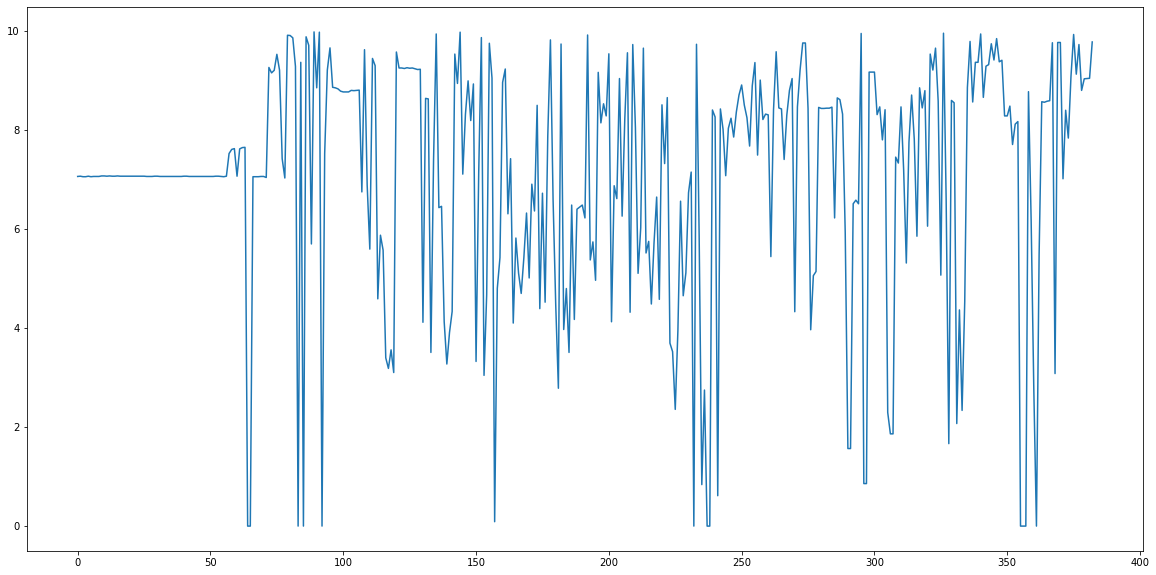

In [141]:
print(len(bottom_left_y))
plt.plot(list(range(len(bottom_left_y))), bottom_left_y)